<a href="https://colab.research.google.com/github/kwanhong66/KaggleShoveling/blob/master/In_depth_skewed_data_classif_(93_recall_acc_now)__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle kernal transcription study #9-1
### Credit Card Fraud Detection

- Kernal 주소
  * https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now#Logistic-regression-classifier---Skewed-data
- Dataset 주소
  * https://www.kaggle.com/mlg-ulb/creditcardfraud

## Dataset with Kaggle API

In [0]:
!pip3 install -q kaggle

In [13]:
!wget 'https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json'

--2020-04-06 02:22:27--  https://raw.githubusercontent.com/kwanhong66/KaggleShoveling/master/token/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63 [text/plain]
Saving to: ‘kaggle.json.1’

kaggle.json.1       100%[===================>]      63  --.-KB/s    in 0s      

2020-04-06 02:22:27 (9.77 MB/s) - ‘kaggle.json.1’ saved [63/63]



In [14]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)    1GB  2020-04-03 22:53:52          43085  
fireballbyedimyrnmom/us-counties-covid-19-dataset              US counties COVID 19 dataset                        268KB  2020-04-05 18:57:09           1285  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            362  
vitaliymalcev/russian-passenger-air-service-20072020           Russian passenger air service 2007-2020             239KB  2020-04-02 22:27:03            259  
bappekim/air-pollution-in-seoul               

In [17]:
!kaggle datasets download mlg-ulb/creditcardfraud 

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
!mkdir input

mkdir: cannot create directory ‘input’: File exists


In [19]:
!unzip '*.zip' -d ./input/

Archive:  creditcardfraud.zip
replace ./input/creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./input/creditcard.csv  


## Credit card fraud detection

This notebook will test different methods on skewed data. The idea is to compare if preprocessing techniques work better when there is an overwhelming majority class that can disrupt the efficiency of our predictive model.

You will also be able to see how to apply cross validation for hyperparameter turning on different classification models. My intention is to create models using:

1. Logistic Regression
2. SVMs
3. Decision trees
4. I also want to have a try at anomaly detection techniques, but I still have to investigate a bit on that, so any advise will be appreciated!

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Loading the dataset


In [21]:
data = pd.read_csv('input/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Checking the target classes

Text(0, 0.5, 'Frequency')

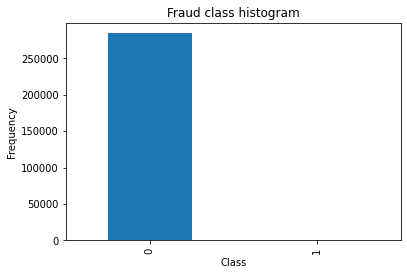

In [22]:
# count_classes = data['Class'].value_counts().to_frame().sort_index()
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
count_classes.plot(kind='bar')
plt.title('Fraud class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

**Clearly the data is totally unbalanced!!**

**This is a clear example where using a typical accuracy score to evaluate our classification algorithm. For example, if we just used a majority class to assign values to all records, we will still be having a high accuracy, BUT WE WOULD BE CLASSIFYING ALL "1" INCORRECTLY!!**

**There are several ways to approach this classification problem taking into consideration this unbalance.**

- Collect more data? Nice strategy but not applicable in this case
- Changing the performance metrics:
  * Use the confusion matrix to calculate Precision, Recall
  * F1-score (weighted average of precision recall)
  * Use Kappa - which is a classification accuracy normalized by the imbalance of the classes in the data
  * ROC curves - calculates sensitivity / specificity ratio
- Resampling the dataset
  * Essentially this is a method that will process the data to have an approximate 50-50 ratio
  * One way to achieve this is by OVER-sampling, which is adding copies of the under-represented class (better when you have little data)
  * Another is UNDER-sampling, which deletes instances from the over-represented class (better when he have lot's of data)

## Approach

1. We are not going to perform feature engineering in first instance. The dataset has been downgraded in order to contain 30 features (28 anonamised + time + amount).

2. We will then compare what happens when using resampling and when not using it. We will test this approach using a simple logisitic regression classifier.

3. We will evaluate the models by using some of the performance metrics mentioned above.

4. We will repeat the best resampling / not resampling method, by tuning the parameters in the logistic regression classifier.

5. We will finally perform classifications model using other classfication algorithms.

## Setting our input and target variables + resampling

1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [23]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time', 'Amount'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


2. Assigning X and Y. No resampling.

3. Resampling.

- As we mentioned earlier, there are several ways to resample skewed data. Apart from under and over sampling, there is a very popular approach called SMOTE (Synthetic Minority Over-Sampling Technique), which is a combination of oversampling and undersampling, but the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

- In this notebook, we will use traditional UNDER-sampling. I will probably try to implement SMOTE in future versions of the code, but for now I will use traditional undersamplig.

- The way we will under sample the dataset will be by creating a 50/50 ratio. This will be done by randomly selecting "x" amount of sample from the majority class, being "x" the total number of records with the minority class.

In [0]:
X = data.loc[:, data.columns != 'Class']
y = data.loc[:, data.columns == 'Class']

In [25]:
# Number of data points in the majority class
number_records_fraud = len(data[data.Class == 1])
fraud_indices = np.array(data[data.Class == 1].index)

# Picking the indices of the normal class
normal_indices = data[data.Class == 0].index

# Out of the indices we picked, randomly select 'x' number (number_records_fraud)
# https://datascienceschool.net/view-notebook/8bf41f87a08b4c44b307799577736a28/
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace=False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

# Under sample dataset
under_sample_data = data.iloc[under_sample_indices, :]

X_undersample = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.loc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0]) / len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1]) / len(under_sample_data))
print('Total number of transactions in resampled data', len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data 984


## Splitting data into train and test set. 

Cross validation will be used when calculating accuracies.

In [26]:
from sklearn.model_selection import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Number of transactions train dataset: ', len(X_train))
print('Number of transactions test dataset: ', len(X_test))
print('Total number of transactions: ', len(X_train)+len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

print('')
print('Number of transactions train dataset: ', len(X_train_undersample))
print('Number of transactions test dataset: ', len(X_test_undersample))
print('Total number of transactions: ', len(X_train_undersample)+len(X_test_undersample))

Number of transactions train dataset:  199364
Number of transactions test dataset:  85443
Total number of transactions:  284807

Number of transactions train dataset:  688
Number of transactions test dataset:  296
Total number of transactions:  984


## Logistic regression classifier - Undersampled data

We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

As we know, due to the imbalacing of the data, many observations could be predicted as False Negatives, being, that we predict a normal transaction, but it is in fact a fraudulent one. Recall captures this.

- Obviously, trying to increase recall, tends to come with a decrease of precision. However, in our case, if we predict that a transaction is fraudulent and turns out not to be, is not a massive problem compared to the opposite.
- We could even apply a cost function when having FN and FP with different weights for each type of error, but let's leave that aside for now.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report

**Very ad-hoc function to print K-fold scores**

In [0]:
def printing_Kfold_scores(x_train_data, y_train_data):
  fold = KFold(n_splits=5, shuffle=False)

  # Different C parameters
  c_param_range = [0.01, 0.1, 1, 10, 100]

  results_table = pd.DataFrame(index=range(len(c_param_range), 2), columns=['C_parameter', 'Mean recall score'])
  results_table['C_parameter'] = c_param_range

  j = 0
  for c_param in c_param_range:
        print('-------------------------------------------')
        print('C parameter: ', c_param)
        print('-------------------------------------------')
        print('')

        recall_accs = []
        for iteration, (train_index, test_index) in enumerate(fold.split(x_train_data)):
          
          # Call the logistic regression model with a certain C parameter
          # The ‘newton-cg’, ‘sag’, and ‘lbfgs’ solvers support only L2 regularization with primal formulation, or no regularization. 
          # The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty. 
          # The Elastic-Net regularization is only supported by the ‘saga’ solver.
          # lr = LogisticRegression(C=c_param, penalty='l1')
          lr = LogisticRegression(C=c_param, penalty='l2')

          # Use the training data to fit the model
          # In this case, we use the portion of the fold to train the model with train_index
          lr.fit(x_train_data.iloc[train_index, :], y_train_data.iloc[train_index, :].values.ravel())

          # Predict values using the test indices in the training data
          y_pred_undersample = lr.predict(x_train_data.iloc[test_index, :].values)

          # Calculate the recall score and append it to a list for recall score representing the current c_parameter
          recall_acc = recall_score(y_train_data.iloc[test_index, :].values, y_pred_undersample)
          recall_accs.append(recall_acc)

          print('Iteration ', iteration,': recall score = ', recall_acc)

        # The mean value of those recall scores is the metric we want to save and get hold of
        results_table.iloc[j, results_table.columns.get_loc('Mean recall score')] = np.mean(recall_accs)
        j += 1
        print('')
        print('Mean recall score ', np.mean(recall_accs))
        print('')

  best_c = results_table.loc[results_table['Mean recall score'].astype(float).idxmax()]['C_parameter']
  # Finally, we can check which C parameter is the best amongst the chosen.
  print('*********************************************************************************')
  print('Best model to choose from cross validation is with C parameter = ', best_c)
  print('*********************************************************************************')
    
  return best_c  

In [33]:
# https://stackoverflow.com/questions/48719937/getting-typeerror-reduction-operation-argmax-not-allowed-for-this-dtype-when
best_c = printing_Kfold_scores(X_train_undersample, y_train_undersample)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  0 : recall score =  0.821917808219178
Iteration  1 : recall score =  0.863013698630137
Iteration  2 : recall score =  0.8983050847457628
Iteration  3 : recall score =  0.9324324324324325
Iteration  4 : recall score =  0.8939393939393939

Mean recall score  0.8819216835933809

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  0 : recall score =  0.8493150684931506
Iteration  1 : recall score =  0.863013698630137
Iteration  2 : recall score =  0.9830508474576272
Iteration  3 : recall score =  0.9324324324324325
Iteration  4 : recall score =  0.8939393939393939

Mean recall score  0.9043502881905482

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  0 : recall score =  0.863013698630137
Iteration  1 : recall score =  0.8767123287671232
Iter

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Iteration  1 : recall score =  0.8767123287671232
Iteration  2 : recall score =  0.9830508474576272
Iteration  3 : recall score =  0.9459459459459459
Iteration  4 : recall score =  0.9090909090909091

Mean recall score  0.921042198033143

*********************************************************************************
Best model to choose from cross validation is with C parameter =  100.0
*********************************************************************************


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


**Create a function to plot a fancy confusion matrix**

In [0]:
import itertools

def plot_confusion_matrix(cm, classes, 
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting 'normalize=True'
  """

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=0)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  thresh = cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
  
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

**Predictions on test set and plotting confusion matrix**

We have been talking about using the recall metrics as our proxy of how effective our predictive models is. Even though recall is still the recall we want to calculate, just bear mind in mind that the undersampled data has not got a skewness towards a certain class, which doesn't make recall metric as critical.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Recall metric in the testing dataset:  0.9387755102040817


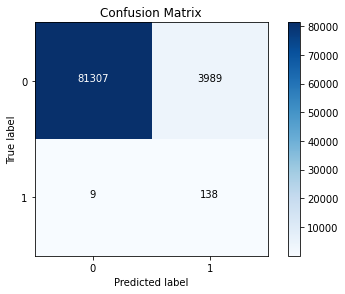

In [41]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test dataset
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ', cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

So, the model is offering an 93.2% recall accuracy on the generalised unseend data (test set). Not a bad percentage to be the first try. However, recall this is a 93.2% recall accuracy measure on the undersampled test set.

In [0]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
lr = LogisticRegression(C=best_c, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_undersample, y_pred_undersample)
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ', cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

# Plot non-normalized confusion matrix
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
plt.show()

Still a very decent recall accuracy when applying it to a much larger and skewed dataset!

We can start to be happy with how initial approach is working.

**Plotting ROC curve and Precision-Recall curve**

- I find precision-recall curve much more convenient in this case as our problems relies on the "positive" class being more interesting than the negative class, but as we have calculated the recall precision, I am not going to plot the precision recall curves yet.

- AUC and ROC curve are also interesting to check if the model is also predicting as a whole correctly and not making many errors

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


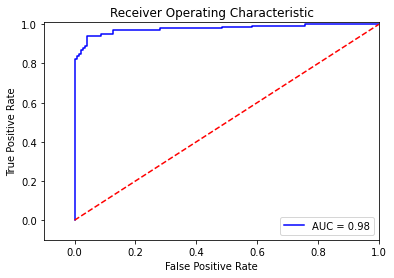

In [42]:
# ROC Curve
lr = LogisticRegression(C=best_c, penalty='l2')
y_pred_undersample_score = lr.fit(X_train_undersample, y_train_undersample.values.ravel()).decision_function(X_test_undersample.values)

fpr, tpr, thresholds = roc_curve(y_test_undersample.values.ravel(), y_pred_undersample_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

An additional comment that would be interesting to do is to initialise multiple undersampled datasets and repeat the process in loop. Remember that, to create an undersample data, we randomly got records from the majority class. Even though this is a valid technique, is doesn't represent the real population, so it would be interesting to repeat the process with different undersample configurations and check if the previous chosen parameters are still the most effective. In the end, the idea is to use a wider random representation of the whole dataset and rely on the averaged best parameters.

## Logistic regression classifier - Skewed data

**Having tested our previous approach, I find really interesting to test the same process on the skewed data. Our intuition is that skewness will introduce issues difficult to capture, and therefore, provide a less effective algorithm.**

- To be fair, taking into account the fact that the train and test datasets are substantially bigger than the undersampled ones, I believe a K-fold cross validation is necessary. I guess that by splitting the data with 60% in training set, 20% cross validation and 20% test should be enough... but let's take the same approach as before (no harm on this, it's just that K-fold is computationally more expensive)

In [43]:
best_c = printing_Kfold_scores(X_train, y_train)

-------------------------------------------
C parameter:  0.01
-------------------------------------------

Iteration  0 : recall score =  0.5373134328358209
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.6666666666666666
Iteration  3 : recall score =  0.6
Iteration  4 : recall score =  0.5

Mean recall score  0.5840836911333742

-------------------------------------------
C parameter:  0.1
-------------------------------------------

Iteration  0 : recall score =  0.5522388059701493
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.7166666666666667
Iteration  3 : recall score =  0.6153846153846154
Iteration  4 : recall score =  0.5625

Mean recall score  0.612645688837163

-------------------------------------------
C parameter:  1
-------------------------------------------

Iteration  0 : recall score =  0.5522388059701493
Iteration  1 : recall score =  0.6164383561643836
Iteration  2 : recall score =  0.7333333333

Recall metric in the testing dataset:  0.6190476190476191


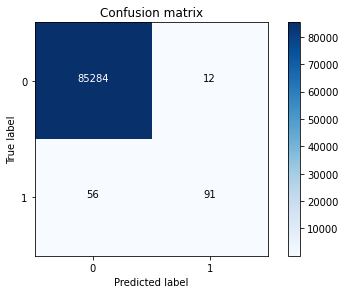

In [44]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test dataset
lr = LogisticRegression(C = best_c, penalty = 'l2')
lr.fit(X_train, y_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=class_names, 
                      title='Confusion matrix')
plt.show()

## Before continuing... changing classification threhold

**We have seen that by undersampling data, our algorithm does a much better job at detecting fraud. I wanted also to show how can we tweak our final classification by changing the threshold.**

- Initially, you build the classification model and then you predict unseen data using it
- We previously used the "predict()" method to decide whether a record should belong to 1 or 0
- There is another method "predict_proba()".
  * This method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control precision and recall.

Let's check this using the undersampled data (best C_param = 100)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Recall metric in the testing dataset:  0.9727891156462585
Recall metric in the testing dataset:  0.9387755102040817
Recall metric in the testing dataset:  0.9387755102040817
Recall metric in the testing dataset:  0.9319727891156463
Recall metric in the testing dataset:  0.9183673469387755
Recall metric in the testing dataset:  0.9183673469387755
Recall metric in the testing dataset:  0.891156462585034
Recall metric in the testing dataset:  0.8707482993197279
Recall metric in the testing dataset:  0.8639455782312925


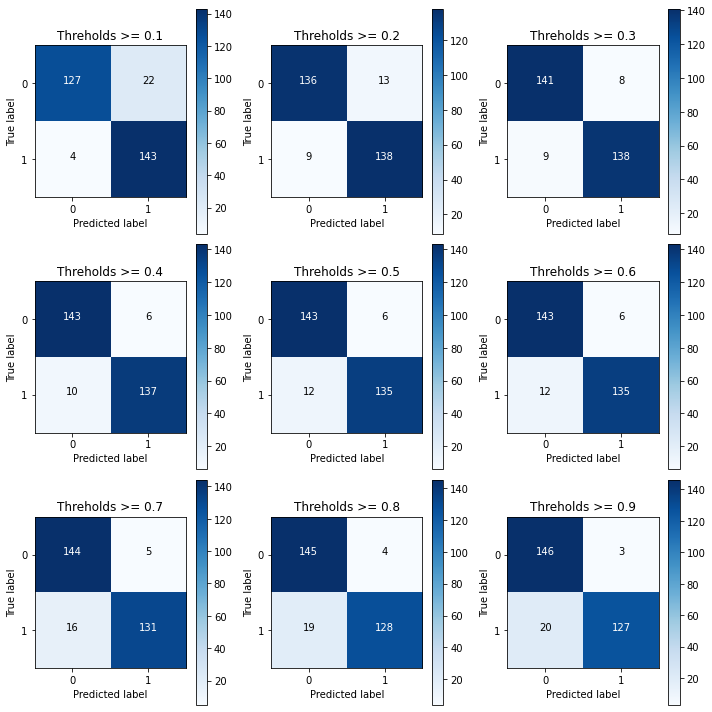

In [45]:
lr = LogisticRegression(C=100, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8 , 0.9]

plt.figure(figsize=(10, 10))

j = 1
for i in thresholds:
  y_test_predictions_high_recall = y_pred_undersample_proba[:, 1] > i

  plt.subplot(3, 3, j)
  j += 1

  # Compute confusion matrix
  cnf_matrix = confusion_matrix(y_test_undersample, y_test_predictions_high_recall)
  np.set_printoptions(precision=2)

  print('Recall metric in the testing dataset: ', cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

  # Plot non-normalized confusion matrix
  class_names = [0, 1]
  plot_confusion_matrix(cnf_matrix,
                        classes=class_names,
                        title='Threholds >= %s' % i)

The pattern is very clear: the more you lower the required probability to put a certain in the class "1" category, more records will be put in that bucket.

This implies an increase in recall (we want all the "1"s), but at the same time, a decrease in precision (we misclassify many of the other class).

Therefore, even though recall is our goal metric (do not miss a fraud transaction), we also want to keep the model being accurate as a whole.

**Investigate Precision-Recall curve and area under this curve.**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


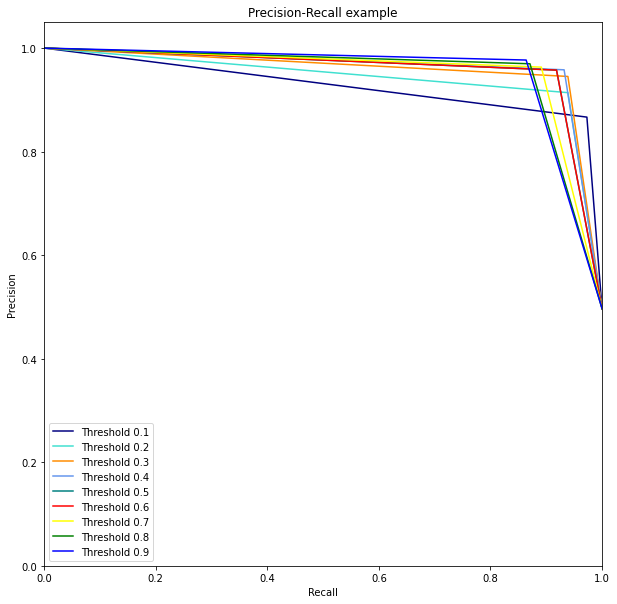

In [50]:
from itertools import cycle

lr = LogisticRegression(C=100, penalty='l2')
lr.fit(X_train_undersample, y_train_undersample.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_test_undersample.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10, 10))

j = 1
for i, color in zip(thresholds, colors):
  y_test_predictions_prob = y_pred_undersample_proba[:, 1] > i

  precision, recall, thresholds = precision_recall_curve(y_test_undersample, y_test_predictions_prob)

  # Plot Precision-Recall curve
  plt.plot(recall, precision, color=color,
           label='Threshold %s' % i)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall example')
  plt.legend(loc='lower left')